In [11]:
import openai
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
from sklearn.metrics.pairwise import  cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
import requests

from sklearn.decomposition import PCA

sns.set_theme(style="whitegrid")

import os
from dotenv import load_dotenv
load_dotenv()

openai.api_key = os.getenv("OPENAI_API_KEY")
HASURA_API_KEY = os.getenv("HASURA_API_KEY")

In [12]:
df = pd.read_parquet("../data/scrna_seq_with_embs.pq")
df = df[~df.embedding.isna()].set_index('pubmed_id')
df.index = df.index.map(lambda x: int(x.split("\n")[0]))
embs = np.concatenate([np.atleast_2d(x) for x in df.embedding.values])

In [18]:
%%time 
paps = requests.get(
    "https://sealver.in/hasura/api/rest/scrnaseq_papers/get",
    auth = requests.auth.HTTPBasicAuth('user', HASURA_API_KEY)
)

paps = DataFrame(paps.json()['ml_scrnaseq_papers']).set_index('pubmed_id')
paps = paps[paps.is_computational][["title", "abstract"]]

CPU times: user 508 ms, sys: 103 ms, total: 611 ms
Wall time: 11 s


In [21]:
df = df.loc[paps.index]
embs = np.concatenate([np.atleast_2d(x) for x in df.embedding.values])

In [50]:
# query = "non-negative matrix factorization (NMF)"
# query = "comparative or case-control analysis"
query = "meta-cells"
# query = "computational methods for analysis of case-control or cohort studies"
# query = "wavelet analysis"
# query = "epilepsy"
# query = "Differential abundance testing on single-cell data using k-nearest neighbor graphs"
response = openai.Embedding.create(input=query, model="text-embedding-ada-002")
query_emb = np.array(response["data"][0]["embedding"])
query_sims = cosine_similarity(embs, np.atleast_2d(query_emb))

APIConnectionError: Error communicating with OpenAI

In [28]:
# plt.hist(query_sims, bins=50);

In [ ]:
# query_sims = cosine_similarity(embs, np.atleast_2d(df.loc[34594043].embedding)) # Milo

In [49]:
sdf = df[["title", "abstract"]].reset_index().join(DataFrame(dict(sim=query_sims[:,0]))).sort_values('sim', ascending=False)
for i in range(50):
    print(round(sdf.sim.values[i], 3))
    print("# " + sdf.title.values[i])
    print(sdf.abstract.values[i])
    print()

1.0
# Differential abundance testing on single-cell data using k-nearest neighbor graphs.
Current computational workflows for comparative analyses of single-cell datasets typically use discrete clusters as input when testing for differential abundance among experimental conditions. However, clusters do not always provide the appropriate resolution and cannot capture continuous trajectories. Here we present Milo, a scalable statistical framework that performs differential abundance testing by assigning cells to partially overlapping neighborhoods on a k-nearest neighbor graph. Using simulations and single-cell RNA sequencing (scRNA-seq) data, we show that Milo can identify perturbations that are obscured by discretizing cells into clusters, that it maintains false discovery rate control across batch effects and that it outperforms alternative differential abundance testing strategies. Milo identifies the decline of a fate-biased epithelial precursor in the aging mouse thymus and identif

## Embed UMAP

In [45]:
from umap import UMAP

In [56]:
%%time
ump = UMAP(n_components=20, metric="cosine")
emb_umaps = ump.fit_transform(embs)

CPU times: user 3min 13s, sys: 2.46 s, total: 3min 16s
Wall time: 22.4 s


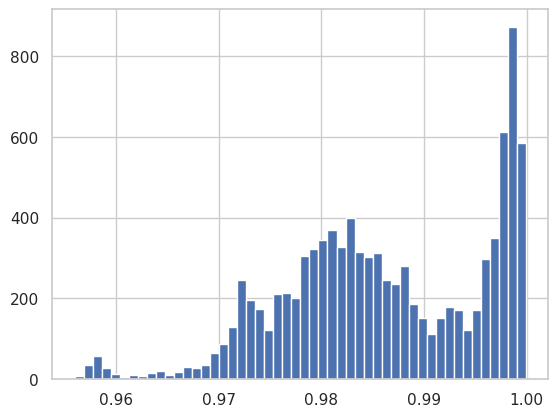

In [57]:
query_sims_umap = cosine_similarity(emb_umaps, ump.transform(np.atleast_2d(query_emb)))
plt.hist(query_sims_umap, bins=50);

In [58]:
sdf = df[["abstract"]].reset_index(drop=True).join(DataFrame(dict(sim=query_sims_umap[:,0]))).sort_values('sim', ascending=False)
for i in range(5):
    print(round(sdf.sim.values[i], 3))
    print(sdf.abstract.values[i])
    print()

1.0
Recent technological advances, such as single-cell RNA sequencing (scRNA-seq), allow the measurement of gene expression profiles of individual cells. These expression profiles typically exhibit substantial variations even across seemingly homogeneous populations of cells. Two main different sources contribute to this measured variability: actual differences between the biological activity of the cells and technical measurement errors. Analysis of the biological variability may provide information about the underlying gene regulation of the cells, yet distinguishing it from the technical variability is a challenge. Here, we apply a recently developed computational method for measuring the global gene coordination level (GCL) to systematically study the cell-to-cell variability in numerical models of gene regulation. We simulate 'biological variability' by introducing heterogeneity in the underlying regulatory dynamic of different cells, while 'technical variability' is represented b

In [48]:
emb_umaps

(9652, 20)

### Embed PCA

In [26]:
pca = PCA()
%time emb_pcs = pca.fit_transform(embs)

CPU times: user 24.2 s, sys: 709 ms, total: 24.9 s
Wall time: 4.55 s


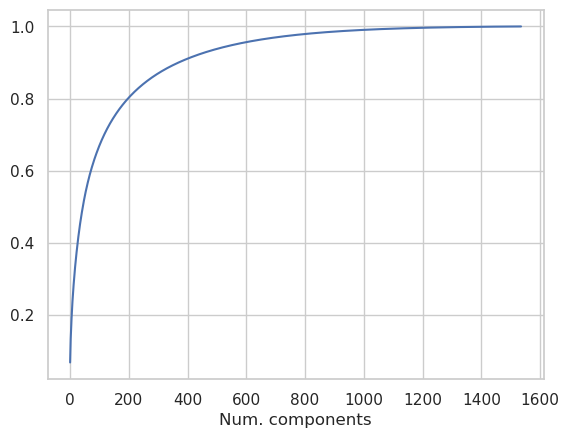

In [27]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Num. components");

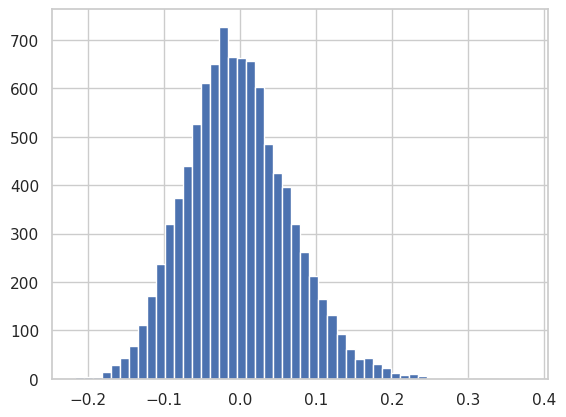

In [32]:
query_sims_pca = cosine_similarity(emb_pcs, pca.transform(np.atleast_2d(query_emb)))
plt.hist(query_sims_pca, bins=50);

In [23]:
sdf = df[["abstract"]].reset_index(drop=True).join(DataFrame(dict(sim=query_sims_pca[:,0]))).sort_values('sim', ascending=False)
for i in range(5):
    print(round(sdf.sim.values[i], 3))
    print(sdf.abstract.values[i])
    print()

0.397
In high-throughput studies, hundreds to millions of hypotheses are typically tested. Statistical methods that control the false discovery rate (FDR) have emerged as popular and powerful tools for error rate control. While classic FDR methods use only p values as input, more modern FDR methods have been shown to increase power by incorporating complementary information as informative covariates to prioritize, weight, and group hypotheses. However, there is currently no consensus on how the modern methods compare to one another. We investigate the accuracy, applicability, and ease of use of two classic and six modern FDR-controlling methods by performing a systematic benchmark comparison using simulation studies as well as six case studies in computational biology.
Methods that incorporate informative covariates are modestly more powerful than classic approaches, and do not underperform classic approaches, even when the covariate is completely uninformative. The majority of methods